# Projeto de ciência de dados

## Pedro Lucas Rocha Almeida Santos

# 1. Introdução
### 1.1 Definição do problema

O problema central deste projeto reside na necessidade de prever, de forma precisa e eficiente, o tempo de parada de caminhões durante o carregamento de vasilhames de GLP, como P13, P20 e P45.
Atualmente, a variação no tempo de permanência pode resultar em ineficiências logísticas, atrasos e dificuldades no planejamento operacional.

### 1.2 Proposta
Utilizar um algoritmo de regressão linear para modelar essa relação busca resolver essa questão, permitindo uma melhor gestão do tempo e otimização dos recursos no processo de carga dos caminhões. As variáveis features serão as quantidades de vasilhames e a target o tempo de permanência.

### 1.3 Hipótese
Por meio da utilização do algoritmo serão encontrados os tempos de permanência de cada cliente do dia conforme a quantidade de vasilhames nas suas respectivas carretas.

### 1.4 Dados
Os dados de treino foram determinados conforme os reais da empresa, porém, por questões confidenciais, não foi possivel utilizar os dados originais, assim, foram estabelecidos com ajuda do chat GPT, uma aproximação conforme os dados reais juntamente a ruídos para aumentar a veracidade.

# 2. Instalando as bibliotecas

In [1]:
pip install pandas odfpy # instala as bibliotecas panda e odfpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160671 sha256=0f9a870d0c3bf8a7c9b98d0dd9443894ace2324c2805961ab9cd2b0ada83e372
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy


# 3. Importando as bibliotecas

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder


# 4. Importando os dados do Github para o código
### 4.1 Importando os dados  e definindos os cabeçalhos


In [22]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/PedroLucasRAS/projetos_cd/refs/heads/main/Dados-Projeto.csv"

# Informa o cabeçalho das colunas
colunas = ['Cliente', 'Qtd de vasilhames P 13', 'Qtd P 45','Qtd  P 20', 'Intervalo de horas']

# Lê o arquivo utilizando as colunas informadas
data = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')


In [4]:
data.head()

,Cliente,Qtd de vasilhames P 13,Qtd P 45,Qtd P 20,Intervalo de horas
0,Cliente 1,152,44,0,0.572
1,Cliente 2,485,0,18,0.775
2,Cliente 3,320,24,9,0.685
3,Cliente 4,156,6,11,0.441
4,Cliente 5,121,8,23,0.476


### 4.2 Definindo o dataset

Os dados estão organizados nas seguintes colunas: **Cliente**, **Qtd de vasilhames P13**, **Qtd de vasilhames P45**, **Qtd de vasilhames P20** e **Intervalo de horas**. As colunas que possuem "Qtd" referem-se à quantidade de vasilhames dos tipos P13, P45 e P20. A coluna "Cliente" contém o nome dos clientes, e a coluna "Intervalo de horas" representa o tempo estimado, em horas, que o caminhão permanece na base. É importante observar que o "Intervalo de horas" está expresso em uma escala de 0 a 1, o que corresponde a um intervalo de 0 a 60 minutos. Portanto, um valor de 0,5, por exemplo, equivale a 30 minutos.

# 5. Análise de dados

### 5.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

Neste ponto temos dados com 5 colunas e 500 linhas.

Os dados de intervalo de tempo estão numérico sendo o resultado de: ((Valor)/60)/24.
Estes é o formato de número do excel para minutos

In [5]:
# Mostra as dimensões do dataset
print(data.shape)

(100, 5)


In [6]:
# Mostra as informações do dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cliente                 100 non-null    object 
 1   Qtd de vasilhames P 13  100 non-null    int64  
 2   Qtd P 45                100 non-null    int64  
 3   Qtd  P 20               100 non-null    int64  
 4   Intervalo de horas      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB
None


In [7]:
# Mostra as 10 primeiras linhas do dataset
data.head(10)

,Cliente,Qtd de vasilhames P 13,Qtd P 45,Qtd P 20,Intervalo de horas
0,Cliente 1,152,44,0,0.572
1,Cliente 2,485,0,18,0.775
2,Cliente 3,320,24,9,0.685
3,Cliente 4,156,6,11,0.441
4,Cliente 5,121,8,23,0.476
5,Cliente 6,750,23,14,1.135
6,Cliente 7,70,0,26,0.400
7,Cliente 8,664,43,21,1.184
8,Cliente 9,171,7,23,0.521
9,Cliente 10,516,23,8,0.871


### 5.2 Tipos de dados e possíveis erros

Visualizando os dados, fica nítido que as colunas, "Qtd de vasilhames P 13",	"Qtd P 45" e	"Qtd P 20" possuem números inteiros e a "Intervalo de horas", possui números decimais como antes citado.
Além disso, a coluna "Cliente" é composta por texto.

Analisando as primeiras linhas, não são visíveis erros evidentes, e os dados parecem estar organizados conforme esperado.

### 5.3 Resumo estatístico


* Dados

In [38]:
# Carregar o dataset diretamente da URL
df = pd.read_csv(url)

# Selecionar apenas as colunas numéricas
dados_numericos = df.select_dtypes(include=['float64', 'int64'])

# Função personalizada para calcular a moda
def calcular_moda(coluna):
    return coluna.mode().iloc[0] if not coluna.mode().empty else None

# Gerar o resumo estatístico
resumo = dados_numericos.describe().T  # .T para transpor o resultado
resumo['mediana'] = dados_numericos.median()
resumo['moda'] = dados_numericos.apply(calcular_moda)
resumo['desvio-padrão'] = dados_numericos.std()
resumo['valores_ausentes'] = dados_numericos.isnull().sum()

# Exibir o resumo estatístico completo
print(resumo[['min', 'max', 'mean', '50%', 'moda', 'desvio-padrão', 'valores_ausentes']])


                           min      max       mean      50%    moda  \
Qtd de vasilhames P 13  51.000  798.000  408.98000  405.500  70.000   
Qtd P 45                 0.000   48.000   23.80000   26.000  38.000   
Qtd P 20                 0.000   29.000   14.58000   16.000  16.000   
Intervalo de horas       0.328    1.294    0.80088    0.782   0.521   

                        desvio-padrão  valores_ausentes  
Qtd de vasilhames P 13     217.789259                 0  
Qtd P 45                    14.292754                 0  
Qtd P 20                     9.249821                 0  
Intervalo de horas           0.230579                 0  


* Visualizações

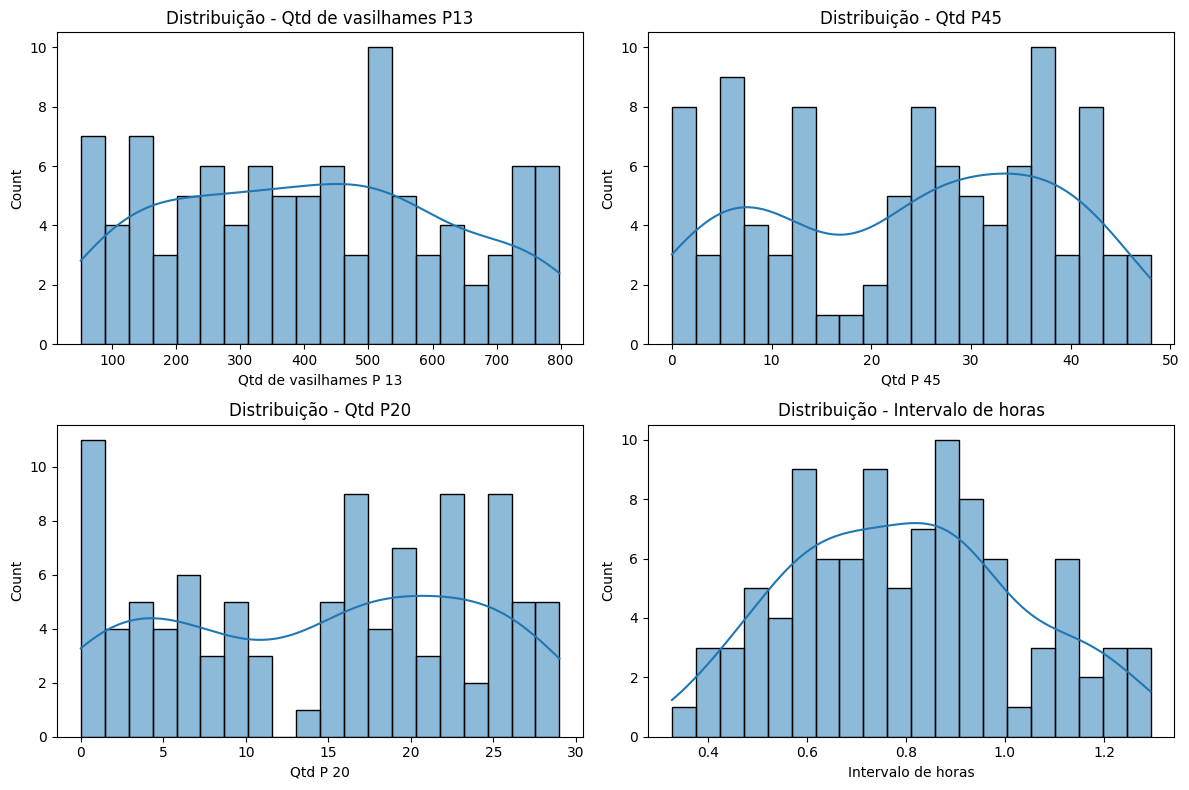

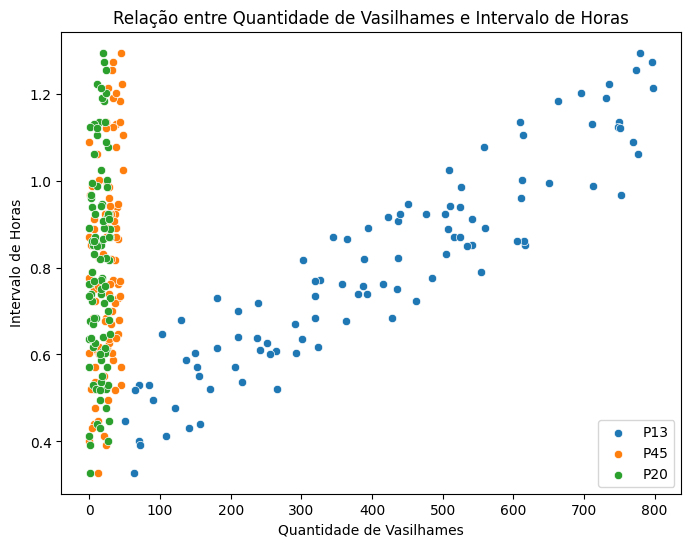

In [39]:
# Histograma para visualizar a distribuição de cada atributo numérico
plt.figure(figsize=(12, 8))

# Subplot 1 - Qtd de vasilhames P13
plt.subplot(2, 2, 1)
sns.histplot(df['Qtd de vasilhames P 13'], bins=20, kde=True)
plt.title('Distribuição - Qtd de vasilhames P13')

# Subplot 2 - Qtd P45
plt.subplot(2, 2, 2)
sns.histplot(df['Qtd P 45'], bins=20, kde=True)
plt.title('Distribuição - Qtd P45')

# Subplot 3 - Qtd P20
plt.subplot(2, 2, 3)
sns.histplot(df['Qtd P 20'], bins=20, kde=True)
plt.title('Distribuição - Qtd P20')

# Subplot 4 - Intervalo de horas
plt.subplot(2, 2, 4)
sns.histplot(df['Intervalo de horas'], bins=20, kde=True)
plt.title('Distribuição - Intervalo de horas')

plt.tight_layout()
plt.show()

# Gráfico de dispersão para ver a relação entre número de vasilhames e intervalo de horas
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Qtd de vasilhames P 13'], y=df['Intervalo de horas'], label='P13')
sns.scatterplot(x=df['Qtd P 45'], y=df['Intervalo de horas'], label='P45')
sns.scatterplot(x=df['Qtd P 20'], y=df['Intervalo de horas'], label='P20')
plt.title('Relação entre Quantidade de Vasilhames e Intervalo de Horas')
plt.xlabel('Quantidade de Vasilhames')
plt.ylabel('Intervalo de Horas')
plt.legend()
plt.show()


### 5.4 Análise do resumo estatístico

 **Dados**

*   A **Qtd de vasilhames P13** apresenta a maior variabilidade, variando de 51 a 798, com uma média de 408,98 e um desvio-padrão de 217,79, sugerindo uma ampla dispersão entre os valores. Resultado esperado, pois é o produto com maior saída e venda na engarrafadora.
*   A **Qtd P45** e **Qtd P20** têm distribuições mais concentradas, com valores médios de 23,8 e 14,58, respectivamente, e modas relativamente próximas das medianas, indicando maior consistência. Resultado também esperado, pois estes produtos são geralmente vendidos para os mesmo clientes com mesmas quantidades.
*   O **Intervalo de horas** varia de 0,33 a 1,29 horas (20 a 78 minutos), com uma média de 48 minutos e desvio-padrão de 0,23, apontando tempos de permanência relativamente uniformes.
*  Não há valores ausentes em nenhum atributo numérico.

**Visualizações**

* Pelos histogramas vemos que os dados de P13 e de horas seguem uma distribuição normal. Por outro lado os de P 45 e P 20 estão com dois picos (Dissimétrica com dois picos) o que alguns dados podem ter sido misturados no processo, ou estarem abordando coisas diferentes.
* Em relação ao gráfico de distribuição, fica claro que o tempo de permanência é principalmente influenciado pela quantidade de P13 acima de P 20 e P 45.


# 6. Preparação dos dados


### 6.1 Normalização logarítmica para as colunas P 20 e P 45

In [48]:
# Aplicando transformação logarítmica
df['Qtd P 45 Log'] = np.log1p(df['Qtd P 45'])
df['Qtd P 20 Log'] = np.log1p(df['Qtd P 20'])

* Foi realizada a normalização para estas colunas, pois conforme demonstrado pelos seus respectivos histogramas, estas não seguiam uma distribuição normal com somente um pico


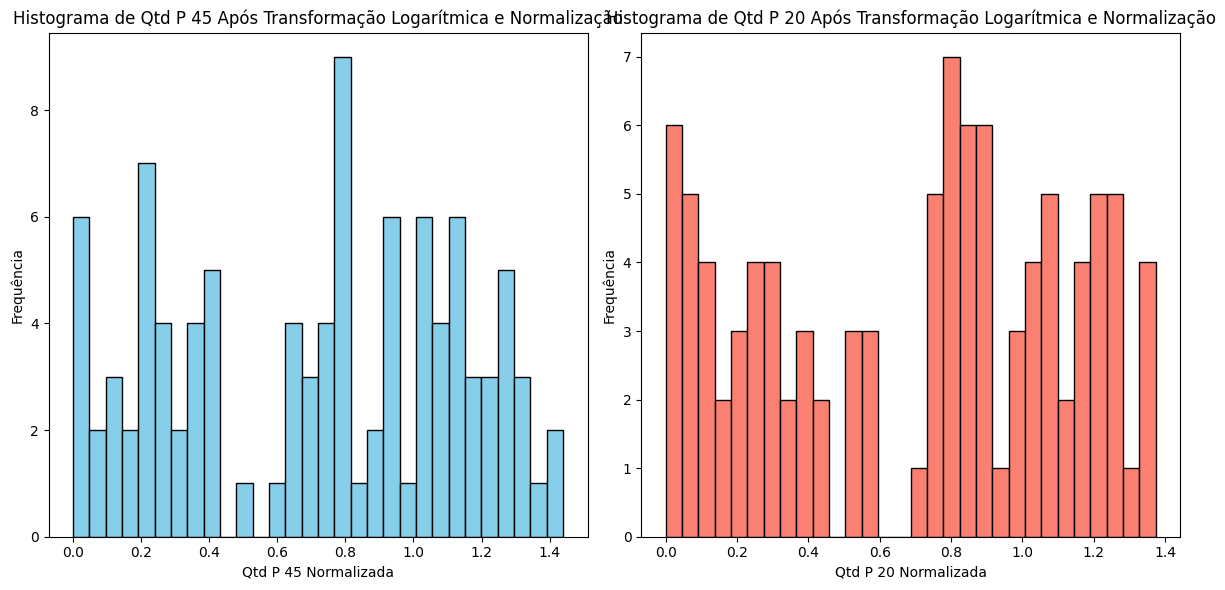

In [49]:
# Criar histogramas para as colunas normalizadas após transformação logarítmica
plt.figure(figsize=(12, 6))

# Histograma para 'Qtd P 45'
plt.subplot(1, 2, 1)
plt.hist(df['Qtd P 45'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Qtd P 45 Após Transformação Logarítmica e Normalização')
plt.xlabel('Qtd P 45 Normalizada')
plt.ylabel('Frequência')

# Histograma para 'Qtd P 20'
plt.subplot(1, 2, 2)
plt.hist(df['Qtd P 20'], bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Qtd P 20 Após Transformação Logarítmica e Normalização')
plt.xlabel('Qtd P 20 Normalizada')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

* Não se chegou a um ponto perfeito, mas com os dados disponíveis é o melhor a se chegar, fica como proposta a utilização de outros dados futuramente para testes e avaliação se o número de **P 45** e **P 20** realmente influenciam no tempo de permanência

### 6.2 Separando os dados em teste e treino

In [50]:
# Selecionando as características e a variável alvo
X = data[['Qtd de vasilhames P 13', 'Qtd P 45','Qtd  P 20']]
y = data['Intervalo de horas']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 7. Implementando e testando o algorítimo de regressão linear

### 7.1 Criando o modelo de regressão e treinando

In [52]:
# Crie e treine o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

* Este modelo foi selecionado de forma interativa conforme testes posteriormente feitos em relação a previsão do modelo

### 7.2 Gráfico de resíduos e Avaliação do modelo

Mean Squared Error (MSE): 1.664003471950572e-32
Mean Absolute Error (MAE): 7.216449660063518e-17
R² Score: 1.0


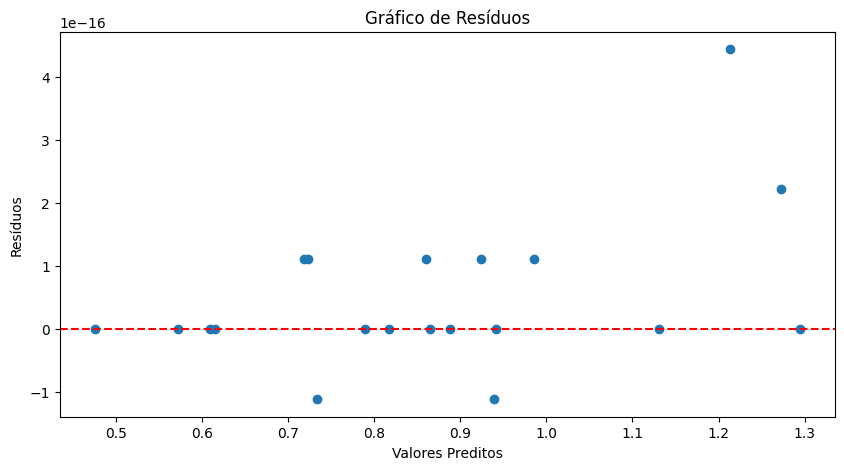

In [53]:
# Prevendo com os dados de teste
y_pred = model.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

Análise
*   O MSE é uma medida que quantifica a média dos erros ao quadrado entre as previsões do modelo e os valores reais. Um MSE próximo de zero indica que o modelo tem um bom ajuste aos dados. Neste caso, o MSE é muito baixo, o que sugere que as previsões do modelo estão muito próximas dos valores reais.
*   O MAE mede a média dos erros absolutos entre as previsões do modelo e os valores reais. Assim como o MSE, um MAE menor indica um melhor desempenho do modelo.
*   O  R² (ou coeficiente de determinação) mede a proporção da variabilidade da variável dependente que pode ser explicada pelo modelo. O R² varia entre 0 e 1, onde 1 indica que o modelo explica 100% da variabilidade nos dados





# 8. Criando um pipeline para comparação de modelos

8.1 Determinando e rodando os algorítmos

In [54]:
# Função para converter numpy.ndarray de volta para DataFrame
def to_dataframe(X):
    return pd.DataFrame(X, columns=['Qtd de vasilhames P 13', 'Qtd P 45', 'Qtd P 20'])

In [55]:
# Definindo a pipeline com imputação e escalonamento
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputação de valores faltantes
    ('scaler', StandardScaler())  # Escalonamento dos dados
])

In [56]:
# Modelos e seus hiperparâmetros
modelos = {
    'Regressão Linear': {
        'modelo': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'modelo': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10]
        }
    },
    'SVR': {
        'modelo': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'KNR': {
        'modelo': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'Árvore de Decisão': {
        'modelo': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    }
}

### 8.2 Mostrando e comparando os resultados


In [57]:
# Carregando os dados
data = pd.read_csv(url)

# Separando variáveis independentes e dependentes
X = data[['Qtd de vasilhames P 13', 'Qtd P 45', 'Qtd P 20']]
y = data['Intervalo de horas']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Armazenar resultados
resultados = []

# Testando os modelos
for nome, config in modelos.items():
    # Criando a pipeline com o pré-processamento e o modelo
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('modelo', config['modelo'])
    ])

    # Ajustando o modelo
    pipeline.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = pipeline.predict(X_test)

    # Avaliando o modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Armazenando os resultados
    resultados.append({'Modelo': nome, 'MSE': mse, 'R²': r2})

# Criando um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

# Exibindo os resultados
print(df_resultados)


              Modelo           MSE        R²
0   Regressão Linear  1.232595e-32  1.000000
1      Random Forest  3.303832e-03  0.934133
2                SVR  2.608739e-03  0.947991
3                KNR  2.628532e-03  0.947596
4  Árvore de Decisão  4.083150e-03  0.918596


### 8.3 Análise:

*   Desta forma, vemos que o melhor modelo é o  de Regressão linear, pois possui um MSE mais baixo que os outros, como também um R² mais próximo do 1 que os outros modelos
*  Assim o notebook foi refeito com o melhor modelo




# 9. Ler os dados da planilha de agendamento do dia

In [70]:
# Agora, vamos ler os dados de outra planilha para fazer as previsões
novos_dados = pd.read_excel('Agendamento.xlsx')

# Preencher valores vazios com zero
novos_dados[['Qtd de vasilhames P 13', 'Qtd P 45','Qtd  P 20']] = novos_dados[['Qtd de vasilhames P 13', 'Qtd P 45','Qtd  P 20']].fillna(0)

### 9.1 Fazendo a previsão

In [ ]:
# Faça a previsão para cada linha e crie uma nova coluna com os resultados em minutos
novos_dados['TEMPO PERMANÊNCIA PREVISTO (minutos)'] = [
    math.ceil(model.predict([[row['Qtd de vasilhames P 13'], row['Qtd  P 20'], row['Qtd P 45']]])[0] * 60)
    for _, row in novos_dados.iterrows()
]

### 9.2 Salvando os dados na nova planilha

In [73]:
# Salve os resultados em uma nova planilha
novos_dados.to_excel('Agendamento com Previsão.xlsx', index=False)

print("Previsões concluídas e salvas em 'Agendamento com Previsão.xlsx'")

Previsões concluídas e salvas em 'Agendamento com Previsão.xlsx'


# 10. Conclusão
* Assim, por meio deste projeto, é possível prever o tempo de permanência dos veículos na planta a partir de um algoritmo de regressão linear. Alguns modelos de regressão foram testados e comparados, e o escolhido foi o modelo de linear regression, pois apresentou os melhores resultados em seus hiperparâmetros em comparação com os demais.
* Fica como próximos passos os testes com dados mais próximos da realidade e verificação da influência de P45 e P20 no tempo de permanência, considerando a nova hipótese que somente o número de P13 pode ser suficiente para uma boa previsão, assim como sugerido pelo gráfico de dispersão.